<a href="https://colab.research.google.com/github/supraja777/small-language-model/blob/main/Small_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Creating Dataset for batched inputs and targets
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt)
    # A sliding window approach
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i: i + max_length]
      target_chunk = token_ids[i + 1: i + max_length + 1]
      # print(tokenizer.decode(input_chunk), "------------>", tokenizer.decode(target_chunk))
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
   return self.input_ids[idx], self.target_ids[idx]


In [18]:
import tiktoken
def create_dataloader_v1(txt, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )
  return dataloader

In [22]:
from IPython.core.displayhook import tokenize
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()

tokenizer = tiktoken.get_encoding("gpt2")

dataloader = create_dataloader_v1(
    raw_text, batch_size = 8, max_length = 4, stride = 4, shuffle = False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs: \n", inputs)
print("\nTarget:\n", targets)

Inputs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Target:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


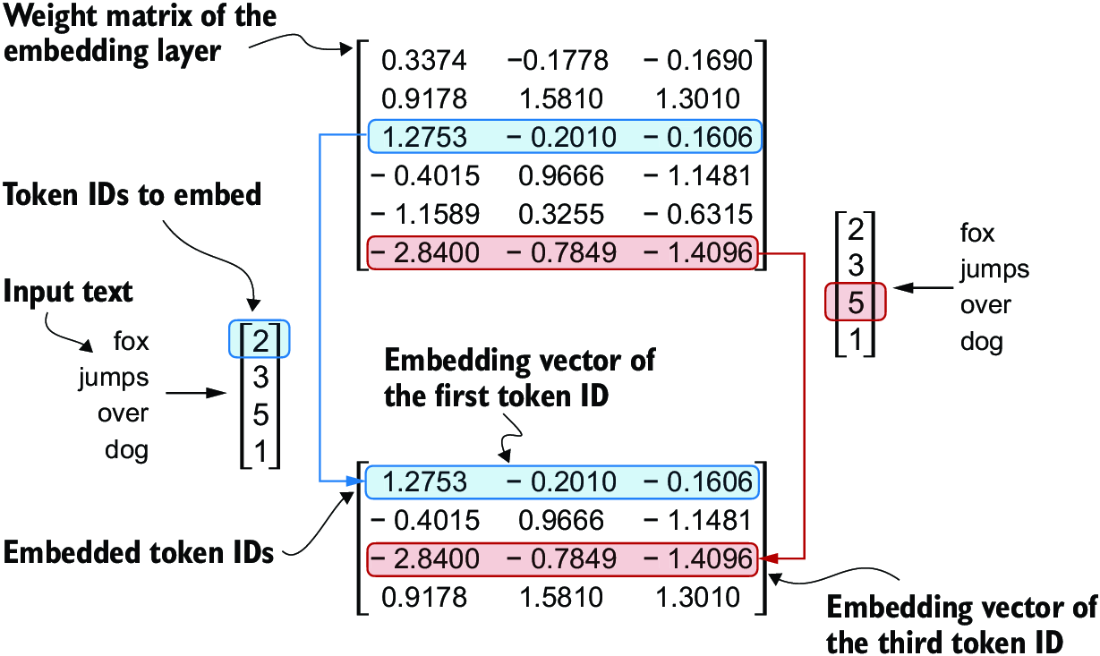

In [25]:
# These values are optimized during LLM training as part of the LLM optimization itself.
# The embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID.
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
print("---------------------------")
print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
---------------------------
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [32]:
vocab_size = 20257 # Vocab size of BPE tkn
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=8,
    max_length=max_length,
    stride=max_length,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs: \n", inputs)
print("Inputs shape: \n", inputs.shape)

Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Inputs shape: 
 torch.Size([8, 4])


In [34]:
vocab_size = 20257 # Vocab size of BPE tkn
ouput_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)
print(token_embeddings)

# Each token is represented using a vector of size 256

torch.Size([8, 4, 256])
tensor([[[-0.2287, -1.0063,  0.6198,  ...,  0.8611, -0.5258, -1.4326],
         [-1.2946,  1.1988, -1.7706,  ...,  1.4640,  0.4287, -0.0470],
         [ 0.0604,  0.8592,  1.6292,  ..., -1.1655, -0.6064,  1.8919],
         [ 1.5132, -0.3390,  0.1458,  ..., -0.3637, -0.5909,  0.0882]],

        [[ 0.4169, -0.2197, -2.1335,  ..., -1.1469, -0.1692,  0.1451],
         [-0.0842,  0.1661,  0.8915,  ...,  0.2171, -0.5817,  0.7787],
         [ 0.5676, -0.4750, -1.0560,  ...,  1.8360,  0.0727,  0.2766],
         [ 1.2552,  0.9581,  0.4697,  ...,  0.5479, -1.2399, -0.8166]],

        [[ 0.2490,  1.2250, -1.7335,  ...,  0.5441, -0.2705,  0.5912],
         [-1.7687, -0.2251,  0.3006,  ...,  1.4832,  1.6158,  1.2908],
         [-0.1912, -1.4511, -0.8454,  ...,  1.7551, -0.2041, -2.3293],
         [ 0.0749, -0.3910,  1.7893,  ..., -0.2285, -1.5846,  0.8829]],

        ...,

        [[-0.9790, -0.1029, -0.2737,  ...,  0.4200,  0.1826,  0.4164],
         [ 0.3567,  0.2851, -0.26

In [37]:
# Creating positional embedding
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embedding = pos_embedding_layer(torch.arange(context_length))
print(pos_embedding)
print(pos_embedding.shape)

tensor([[-0.3116,  0.5972, -1.0052,  ...,  1.2209,  0.4426, -0.4277],
        [ 0.3520,  0.0829,  1.0136,  ...,  0.1426, -0.4406, -1.1736],
        [ 0.4694, -0.4405,  2.0759,  ...,  0.0100,  2.2082,  1.5951],
        [ 0.9800,  0.0950,  1.1506,  ...,  0.7868, -3.0765,  0.5841]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 256])


 We can now add these directly to the token embeddings, where PyTorch will add the 4 × 256–dimensional pos_embeddings tensor to each 4 × 256–dimensional token embedding tensor in each of the eight batches:

In [38]:
input_embeddings = token_embeddings + pos_embedding
print(input_embeddings.shape)

torch.Size([8, 4, 256])


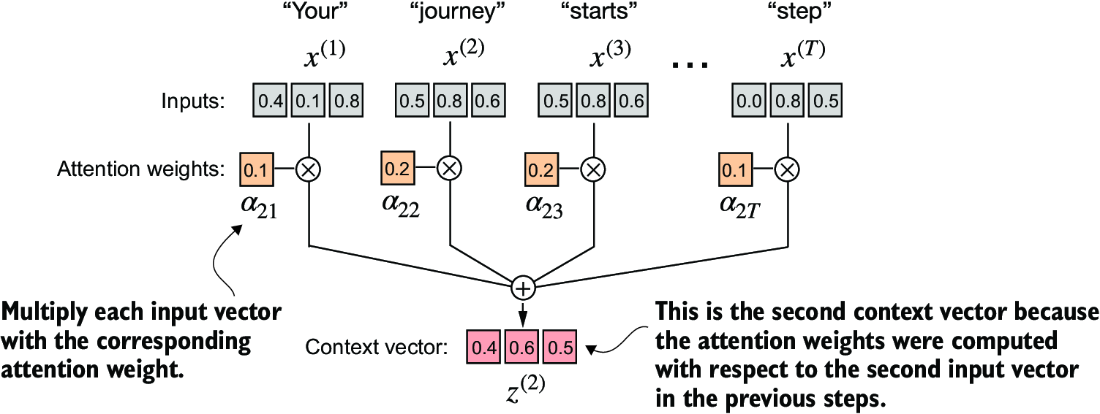

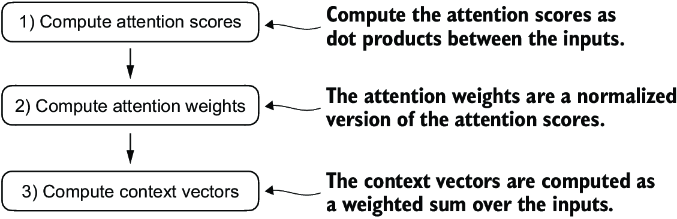

In [39]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in, d_out))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out))


  def forward(self, x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value

    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim = -1
    )
    context_vec = attn_weights @ values
    return context_vec

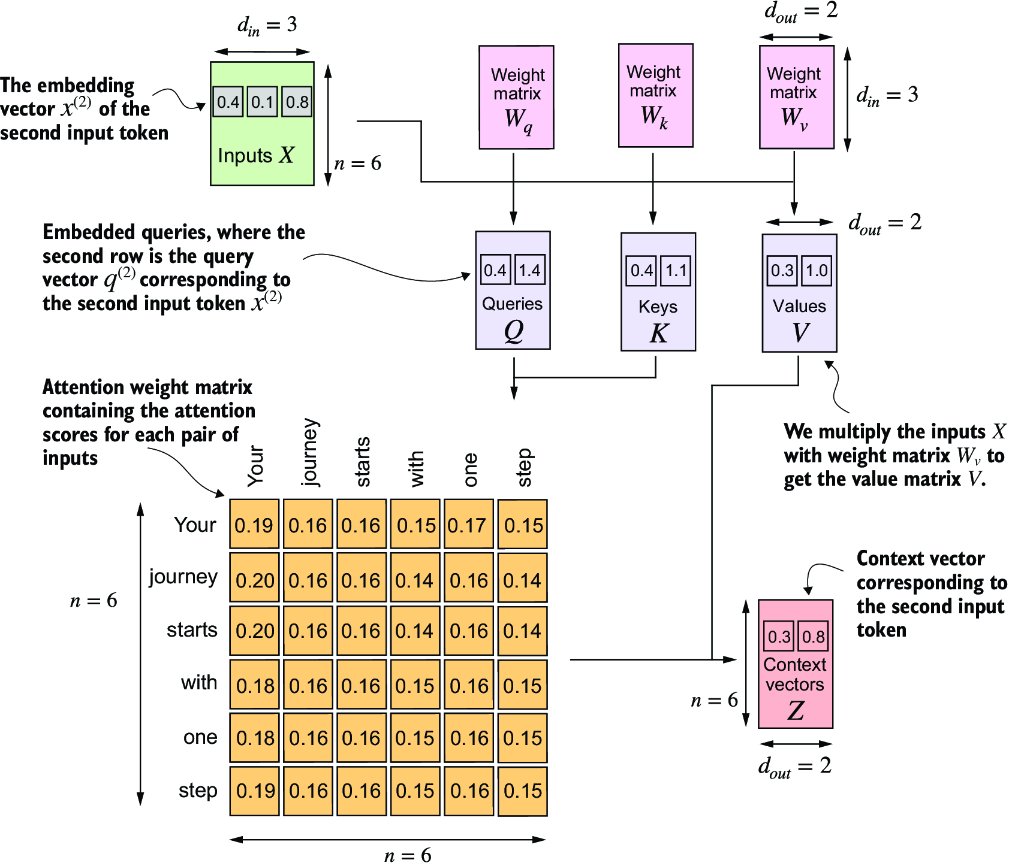

# Masking future values

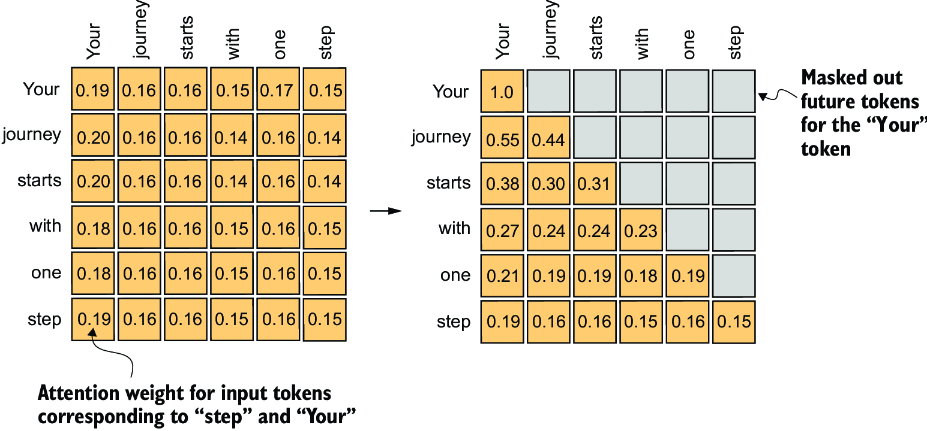

In [40]:
class CasualAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values



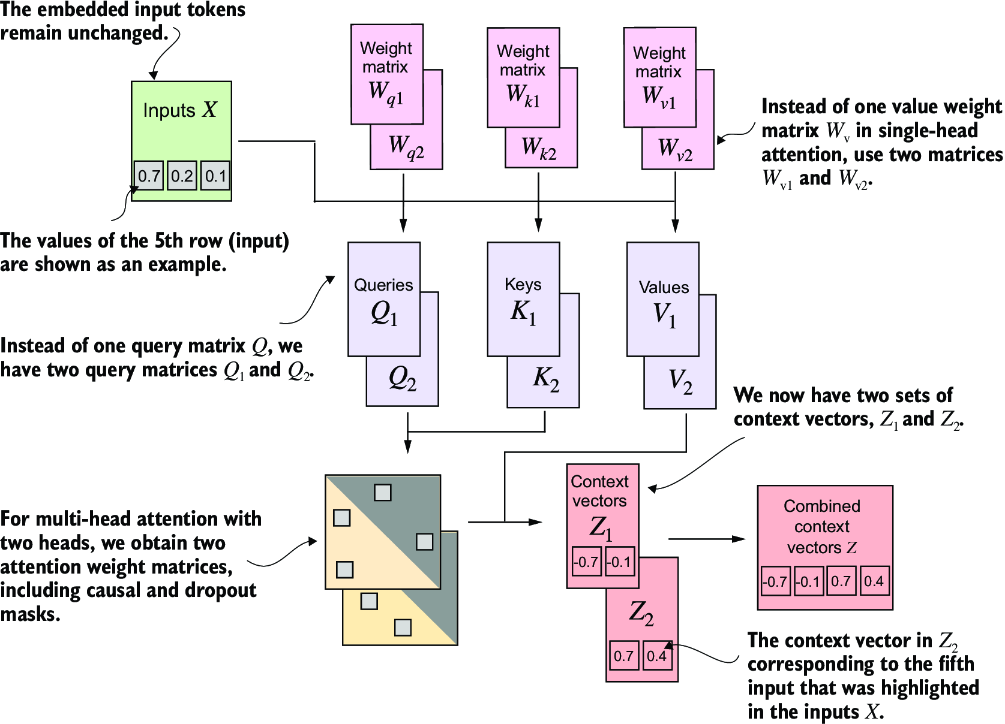